/var/folders/sd/x6b24fj17sg_pd8tj67xfp4r0000gn/T/ipykernel_36131/2635492947.py:69: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='ffill', inplace=True)


Fitting ARIMA model...


/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Model AIC: 4276.76

Evaluation:
R²: -0.6316
MAE: 18.1083
MSE: 391.9292
RMSE: 19.7972

Exogenous Feature Coefficients:
copper_price         1.154043e+01
gold_close           7.675073e+00
unemployment_rate    6.496232e+00
gold_high           -5.737833e+00
treasury_10y        -5.201144e+00
treasury_3m          4.824234e+00
gold_low            -4.409205e+00
google_index_fund    2.289219e+00
google_spx          -2.231056e+00
google_sp500        -9.940246e-01
oil_high            -4.387045e-01
oil_open             1.714543e-01
oil_close            1.520697e-01
oil_low              1.077732e-01
google_etf          -7.854203e-02
oil_volume          -1.150478e-07
gold_volume         -3.938883e-08
bitcoin_open                  NaN
bitcoin_high                  NaN
bitcoin_low                   NaN
bitcoin_close                 NaN
bitcoin_volume                NaN
gold_open                     NaN
dtype: float64


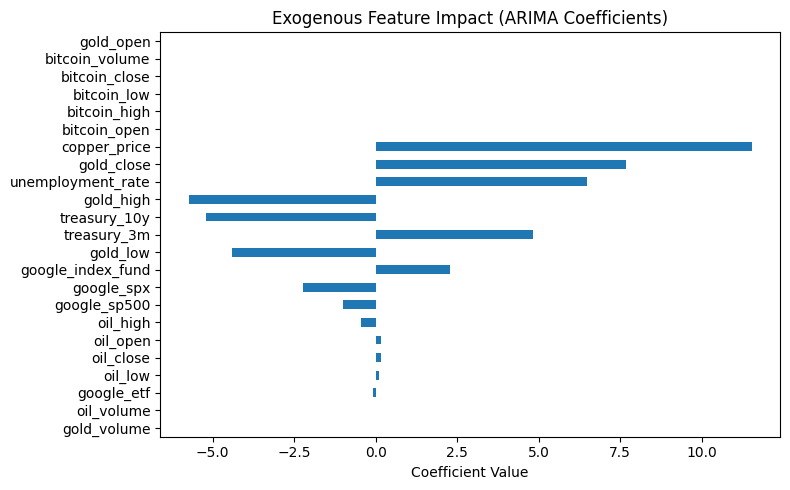

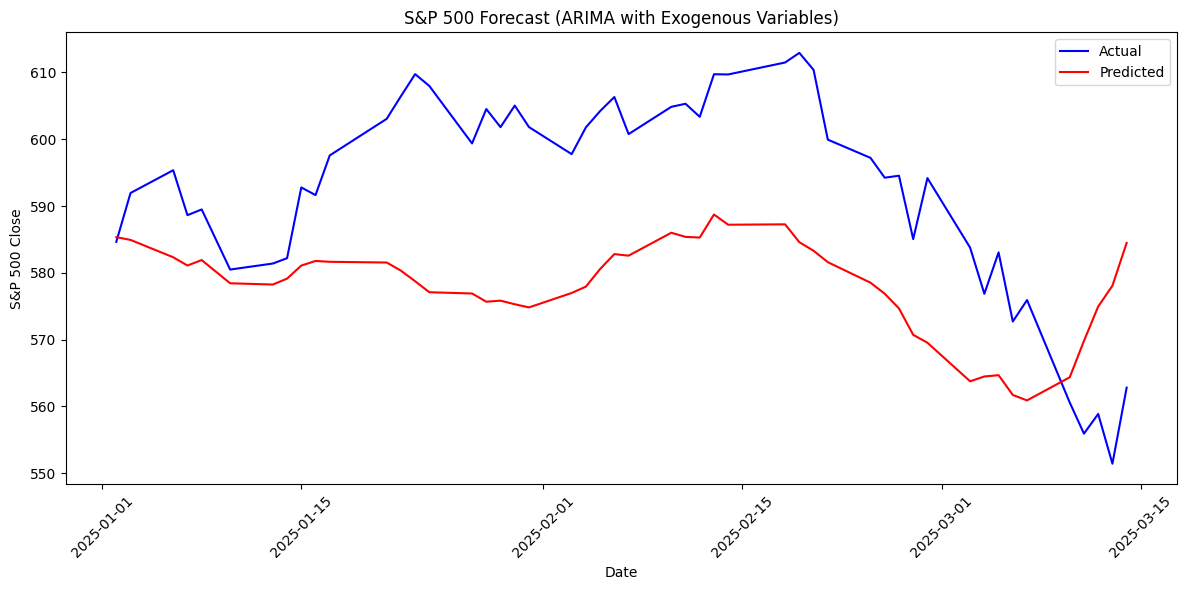

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define file path
data_path = "data"
file_names = {
    "bitcoin": "bitcoin.csv",
    "gold": "gold.csv",
    "google_trends": "google_trends.csv",
    "sp500": "sp500.csv",
    "treasury_3m": "treasury_3m.csv",
    "treasury_10y": "treasury_10y.csv",
    "copper": "copper.csv",
    "oil": "oil.csv",
    "unemployment": "unemployment.csv"
}

# Load and clean datasets
data = {}
for key, file in file_names.items():
    file_path = os.path.join(data_path, file)
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path)
            if "timestamp" not in df.columns:
                print(f"Skipping {key}: 'timestamp' column missing in {file}")
                continue
            df["timestamp"] = pd.to_datetime(df["timestamp"])
            df.replace({'.': np.nan}, inplace=True)
            for col in df.columns:
                if col != "timestamp":
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            data[key] = df
        except Exception as e:
            print(f"Error loading {file}: {e}")
    else:
        print(f"File not found: {file_path}")

# Rename columns for clarity
rename_map = {
    "bitcoin": {"Close": "bitcoin_close", "Open": "bitcoin_open", "High": "bitcoin_high", "Low": "bitcoin_low", "Volume": "bitcoin_volume"},
    "gold": {"Close": "gold_close", "Open": "gold_open", "High": "gold_high", "Low": "gold_low", "Volume": "gold_volume"},
    "oil": {"Close": "oil_close", "Open": "oil_open", "High": "oil_high", "Low": "oil_low", "Volume": "oil_volume"},
    "copper": {"price": "copper_price"},
    "google_trends": {"SPX": "google_spx", "ETF": "google_etf", "index fund": "google_index_fund", "sp500": "google_sp500"},
    "unemployment": {"Unemployment": "unemployment_rate"},
    "treasury_3m": {"Close": "treasury_3m"},
    "treasury_10y": {"Close": "treasury_10y"},
    "sp500": {"Close": "sp500_close"}
}

for key, renames in rename_map.items():
    if key in data:
        data[key] = data[key].rename(columns=renames)

# Merge all datasets on timestamp
sp500 = data["sp500"]
all_data = sp500[["timestamp", "sp500_close"]]
for key, df in data.items():
    if key != "sp500" and df is not None:
        all_data = all_data.merge(df, on="timestamp", how="left")

# Sort and fill missing values
all_data.sort_values("timestamp", inplace=True)
all_data.fillna(method='ffill', inplace=True)
all_data.dropna(inplace=True)

# Drop lingering _x/_y columns (if any)
all_data = all_data[[col for col in all_data.columns if not col.endswith(("_x", "_y"))]]

# Define target and exogenous variables
target = "sp500_close"
exclude_cols = ["timestamp", target]
exog_vars = [col for col in all_data.columns if col not in exclude_cols]

# Split using fixed date (Jan 1, 2025)
split_date = pd.Timestamp("2025-01-01")
train = all_data[all_data["timestamp"] < split_date]
test = all_data[all_data["timestamp"] >= split_date]

y_train = train[target]
y_test = test[target]
X_train = train[exog_vars]
X_test = test[exog_vars]

# Fit ARIMA model with exogenous variables
print("Fitting ARIMA model...")
model = SARIMAX(y_train, exog=X_train, order=(5, 1, 0), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Print AIC
print(f"\nModel AIC: {model_fit.aic:.2f}")

# Forecast
forecast = model_fit.forecast(steps=len(X_test), exog=X_test)
forecast = forecast.values

# Evaluation
r2 = r2_score(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)

print("\nEvaluation:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# Feature importance: map last N params to exog_vars
print("\nExogenous Feature Coefficients:")
exog_coeffs = pd.Series(model_fit.params[-len(exog_vars):], index=exog_vars)
print(exog_coeffs.sort_values(key=abs, ascending=False))

# Plot feature importance
exog_coeffs.sort_values(key=abs).plot(kind="barh", figsize=(8, 5), title="Exogenous Feature Impact (ARIMA Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(test["timestamp"], y_test, label="Actual", color='blue')
plt.plot(test["timestamp"], forecast, label="Predicted", color='red')
plt.title("S&P 500 Forecast (ARIMA with Exogenous Variables)")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
